<font size="6"> **Statistical Risk Model** </font>

$$ \vec{r}(N,T) = \vec{\beta}(N,K) · \vec{f}(K,T) + \vec{s}(N,T)$$

* from $\vec{f}$ compute `factor covariance matrix`: $\vec{F}$
* from $\vec{s}$ compute `idiosyncratic covariance matrix` $\vec{S}$ and extract diagonal

Use  $\vec{\beta}$, $\vec{F}$ and $\vec{S}$ to estimate portfolio risk: $\sigma_{r_{p}}$

In [12]:
%%capture
%run 01_portopt_data.ipynb

In [99]:
import matplotlib.pyplot as plt
import scipy
import pickle
import datetime as dt

from mle_quant_utils import portopt_utils
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [14]:
import yaml
import os

# Retrieve parameters from configuration file
with open("../conf.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile)

In [15]:
RND_SEED = 123
risk_aversion = 1.0e-6

In [16]:
pd.concat([daily_returns.head(2), daily_returns.tail(2)],axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2015-05-28 00:00:00+00:00,-0.004683,-0.006383,-0.005534,-0.002000,0.001341,-0.004308,0.005088,0.001448,-0.001809,0.000284,...,-0.004758,0.002820,0.000000,0.005400,0.006105,0.005479,-0.001949,-0.007701,-0.004797,-0.006864
2015-05-29 00:00:00+00:00,-0.012719,0.009538,-0.020019,-0.011390,-0.013042,-0.004782,-0.013383,-0.008980,-0.011560,-0.005119,...,0.001594,-0.007940,0.001050,-0.002207,-0.006944,-0.003519,-0.018412,0.006169,-0.008223,0.013427
2015-12-24 00:00:00+00:00,-0.003682,0.012022,0.000465,-0.005341,-0.002041,0.000090,0.000000,-0.001820,-0.004224,0.005673,...,0.009623,-0.000620,-0.010724,-0.002127,0.005553,-0.001614,-0.001620,0.001364,0.003975,0.003121
2015-12-28 00:00:00+00:00,0.007040,-0.013259,0.009526,-0.011204,0.004953,0.002309,-0.001550,-0.001441,-0.001060,-0.006164,...,0.000503,-0.001064,-0.007439,0.004930,-0.021138,-0.003484,-0.002177,-0.006413,-0.005033,-0.004784


In [17]:
def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        _h0 = h0.values
        factor_risk = 0.5*risk_aversion*np.sum( np.matmul(Q,h)**2 )
        idiosyncratic_risk = 0.5*risk_aversion*np.dot(h**2, specVar)  # specVar is diag
        exp_port_ret = np.dot(h, alpha_vec)
        trans_costs = np.dot((h-_h0)**2, Lambda)
        obj_f = factor_risk + idiosyncratic_risk - exp_port_ret + trans_costs
        return(obj_f)
    
    return obj_func

In [18]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        
        grad_factor_risk = risk_aversion*np.matmul(QT, np.matmul(Q,h))
        grad_idiosyncratic_risk = risk_aversion*specVar*h
        grad_exp_port_ret =  alpha_vec
        grad_trans_costs = 2*(h-h0)*Lambda
        
        g = grad_factor_risk + grad_idiosyncratic_risk - grad_exp_port_ret + grad_trans_costs
        
        return(np.asarray(g))
    
    return grad_func

In [19]:
def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)


    optimizer_result = scipy.optimize.fmin_l_bfgs_b(
        func=obj_func, x0=h0, fprime=grad_func
    )
    return optimizer_result[0]

In [20]:
risk_model.keys()

dict_keys(['factor_var_vector', 'factor_betas', 'idiosyncratic_var_vector', 'factor_returns'])

In [21]:
risk_facret = risk_model['factor_returns']
#alpha_facret

In [22]:
B = risk_model['factor_betas']
B.shape

(490, 20)

In [23]:
Fvar = np.diag(risk_model['factor_var_vector'].values[:,0])
Fvar.shape

(20, 20)

In [58]:
# alphas
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed']
B_alpha = features_df[alpha_factors]
alpha_vec = B_alpha.mean(axis=1)
alpha_vec[:5]

date                       asset
2013-01-03 00:00:00+00:00  A       -3.327787
                           AAL      0.639552
                           AAP     -1.567522
                           AAPL     0.085905
                           ABBV    -1.949210
dtype: float64

In [59]:
# data alignment: static frame
str_date_fmt = "%Y%m%d"
betas_exp = {}
# factor_cov = {}
spec_var = {}
lambdas = {}

for dt_idx in daily_returns.index:
    dt_idx_str = dt.datetime.strftime(dt_idx, str_date_fmt)
    universe = ml_alpha.loc[dt_idx].index
    betas_exp[dt_idx_str] = B.loc[universe]
    
    spec_var[dt_idx_str] = risk_model['idiosyncratic_var_vector'].loc[universe, '0']
    lambdas[dt_idx_str] = adv.loc[dt_idx, universe] * 0.1

In [60]:
example_dt = dt.datetime.strftime(universe_start_date, str_date_fmt)

# risk
BT = betas_exp[example_dt].T
Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()
specVar = spec_var[example_dt]
# cost
Lambda = lambdas[example_dt]


In [90]:

current_alpha_vec = alpha_vec.loc[universe_start_date]#*1e-4
h0 = pd.Series(index=current_alpha_vec.index, data=np.zeros(len(current_alpha_vec)))

In [65]:
h_star = get_h_star(risk_aversion, Q, QT, specVar, current_alpha_vec, h0, Lambda)
h_star[:5]

array([ 1.99208082e-06,  1.28711123e-06, -1.00943631e-05,  1.48217371e-07,
       -5.35634591e-08])

In [66]:
h_star.sum()

0.00010361872733426135

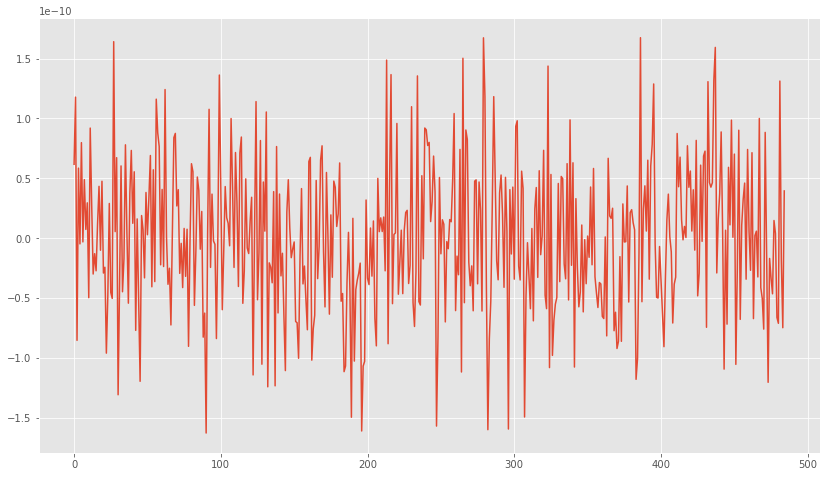

In [57]:
plt.plot(h_star)

In [67]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    return np.dot(Lambda, (h_star-h0)**2)

In [68]:
total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
total_transaction_costs

0.001854258353670916

In [69]:
def get_risk_exposures(BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    
    # TODO: Implement
    factor_names = BT.index
    risk_exposures = np.dot(BT, h_star)
    return pd.Series(index=factor_names, data=risk_exposures)



In [70]:
risk_exposures = get_risk_exposures(BT, h_star)
risk_exposures[:5]

0   -0.000004
1    0.000032
2   -0.000015
3   -0.000007
4   -0.000005
dtype: float64

In [82]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    alpha_factor_cols = B_alpha.columns
    return pd.Series(np.matmul(B_alpha.transpose(), h_star), index=alpha_factor_cols)

In [83]:
portfolio_alpha_exposure = get_portfolio_alpha_exposure(current_alpha_vec.to_frame('ML_ALPHA'), h_star)
portfolio_alpha_exposure[:5]

ML_ALPHA    0.00371
dtype: float64

In [112]:
def form_optimal_portfolio(universe_returns, h_prev, risk_aversion, Fvar, betas_exp, alpha_fac, spec_var, lambdas, dt_idx):
    dt_idx_str = dt.datetime.strftime(dt_idx, str_date_fmt)

    # universe
    universe = universe_returns.loc[dt_idx].index
    h_prev_cp = h_prev.loc[universe].copy()
    
    # Beta exposures
    B = betas_exp[dt_idx_str]
    BT = B.transpose()
    # Factor covariance matrix
    # Fvar as argument
    # Specific variance
    specVar = spec_var[dt_idx_str]
    # Transaction costs
    Lambda = lambdas[dt_idx_str]
    # alpha factor
    alpha_vec = alpha_fac.loc[dt_idx]#*1e-4
    
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h_prev, Lambda)
    #opt_portfolio = pd.DataFrame(data = {"asset" : universe, "h.opt" : h_star})
    
    #risk_exposures = get_risk_exposures(BT, h_star)
    #portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
    #total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
    #
    #results = {
    #    "opt.portfolio" : opt_portfolio, 
    #    "risk.exposures" : risk_exposures, 
    #    "alpha.exposures" : portfolio_alpha_exposure,
    #    "total.cost" : total_transaction_costs}
    return h_star

In [113]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

In [ ]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

In [115]:
trades = {}
port = {}

bkt_dates = [universe_start_date]
h_prev = h0
for dt_idx in tqdm(bkt_dates, desc='Optimizing Portfolio', unit='day'):
    h_current = form_optimal_portfolio(daily_returns, h_prev,  risk_aversion, Fvar, betas_exp, alpha_vec, spec_var, lambdas, dt_idx)
    h_prev = h_current.copy()

Optimizing Portfolio:   0%|          | 0/1 [00:00<?, ?day/s]C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
Optimizing Portfolio: 100%|██████████| 1/1 [00:00<00:00, 14.32day/s]


In [116]:
h_current

array([ 1.99208082e-06,  1.28711123e-06, -1.00943631e-05,  1.48217371e-07,
       -5.35634591e-08,  5.52213103e-06, -8.87876170e-08,  3.15371041e-06,
        4.79197841e-07,  1.60040943e-06, -2.00855715e-06,  7.41409361e-06,
        9.13057188e-06, -1.67470270e-06, -1.24078655e-06, -1.40391419e-06,
        2.28405652e-07,  3.23753791e-06, -3.17180862e-07,  2.57449845e-06,
       -5.40410891e-07, -2.70713675e-06, -1.81707176e-05, -5.70204559e-06,
        2.49026751e-06, -5.51611582e-06, -7.96957721e-06,  1.84413878e-05,
        2.79595520e-07,  1.25764089e-05, -7.40668934e-06, -1.69025155e-07,
        5.31887848e-07, -5.67356935e-06, -6.82826810e-06,  3.06929045e-06,
        4.27993074e-07, -2.99170815e-06,  1.35289412e-06,  4.14451653e-06,
        4.67156454e-06,  4.17455691e-06, -7.33108520e-06,  1.93988423e-06,
       -2.07642932e-06, -3.79908170e-06,  2.27965542e-06,  1.00216329e-06,
       -1.33754894e-05,  7.60735809e-07,  7.75852874e-08,  7.23508372e-06,
        2.83910298e-06, -

In [88]:
trades = {}
port = {}

for dt in tqdm(bkt_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime(str_date_fmt)
    # h0 = pd.Series(index=current_alpha_vec.index, data=np.zeros(len(current_alpha_vec)))
    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    #trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio:   0%|          | 0/1 [00:00<?, ?day/s]


NameError: name 'frames' is not defined